In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import curve_fit
import sklearn.gaussian_process as gp
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

from utils.model import hill_activation, hill_activation_single, hill_activation_and, hill_activation_and_fixed, random_search
from utils.helper import generate_data_at_t, generate_data_at_t_2, sum_squared_error, \
                       get_blank_corrected, get_neg_ctrl_corrected, get_pos_ctrl_corrected, \
                       generate_data, setup_header, read_map
from utils.plotter import plot_heatmap

In [22]:
folder = '033-all-and-gates-characterization'
#ara = [0, 0.8125, 3.25, 13, 52, 208]
#cuma = [0, 6.25, 12.5, 25, 50, 100]
ara = [0, 0.8125, 1.625, 3.25, 6.5, 13]
cuma = [0, 6.25, 12.5, 25, 50, 100]

hill_params = {
    'ara': [0.88, 0.3, 0.32, -2.85],
    'cuma': [0.1, 1.82, 0.49, -2.9]
}

#### Actual inducers

In [23]:
aras = ara.copy()
cumas = cuma.copy()
aras, cumas

([0, 0.8125, 1.625, 3.25, 6.5, 13], [0, 6.25, 12.5, 25, 50, 100])

In [24]:
def build_plate_map(P1, P2):

    plate_map_builder = [[P1] * 6 + [P2] * 6 for _ in range(6)]
    plate_map_builder.append([np.NaN] * 12)
    plate_map_builder.append([np.NaN, np.NaN, 'BK', 'BK', '3K3-N', '3K3-N', 'BA', 'BA', '4A3-N', '4A3-N', '4A3-P', '4A3-P'])
    plate_map = pd.concat([pd.Series(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']),
               pd.DataFrame(np.array(plate_map_builder))], axis=1)
    plate_map.columns = ['group', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    
    return plate_map

In [25]:
actual_heatmaps = []
responses = []
for i in tqdm(range(1, 7)):
    ctrl_map = [(0, 2)] if i!=6 else [(0, 1)]
    samples_t = generate_data_at_t(folder, 'induction_matrix/plate{}'.format(i),
                                   '/induction_matrix/plate{}_map'.format(i),
                                   kind='2-input induction matrix', pos_ctrl_map=ctrl_map)[0]
    
    for gate in sorted(list(set(samples_t.index.str[:-3].tolist()))):
        
        fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
        fluo_t['cuma'] = fluo_t['name'].str[-2].astype(int)
        fluo_t['cuma'] = fluo_t['cuma'].apply(lambda x: cumas[x])
        fluo_t['ara'] = fluo_t['name'].str[-1].astype(int)
        fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])
        
        fluo_t = fluo_t.rename(columns={'8 h ': 'actual'})
        
        actual = fluo_t[['actual', 'cuma', 'ara']].pivot('cuma', 'ara')
        actual.index = [np.round(cm, 3) for cm in cumas]
        actual.columns = [np.round(ar, 3) for ar in aras]
        actual_heatmaps.append((gate, actual, fluo_t))

 33%|███████████████                              | 2/6 [00:00<00:00, 12.90it/s]

[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]
[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]
[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.34it/s]

[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]
[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]
[('A', 'sample'), ('B', 'positive')]


In [26]:
gates_list = pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder))

for i in tqdm(range(len(gates_list))):
    
    P1, P2 = gates_list.iloc[i].tolist()
    a, b = str(i*2+1).zfill(3), str(i*2+2).zfill(3)
    
    samples_t = generate_data_at_t_2(folder, '{}-{}'.format(a, b),
                                   build_plate_map(P1, P2),
                                   kind='2-input induction matrix', pos_ctrl_map=[(0, 1)],
                                   single_timepoint=True)[0]
    
    for gate in sorted(list(set(samples_t.index.str[:-3].tolist()))):
        
        fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
        fluo_t['cuma'] = fluo_t['name'].str[-2].astype(int)
        fluo_t['cuma'] = fluo_t['cuma'].apply(lambda x: cumas[x])
        fluo_t['ara'] = fluo_t['name'].str[-1].astype(int)
        fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])
        
        fluo_t = fluo_t.rename(columns={0: 'actual'})
        
        actual = fluo_t[['actual', 'cuma', 'ara']].pivot('cuma', 'ara')
        actual.index = [np.round(cm, 3) for cm in cumas]
        actual.columns = [np.round(ar, 3) for ar in aras]
        actual_heatmaps.append((gate, actual, fluo_t))

100%|███████████████████████████████████████████| 55/55 [00:02<00:00, 24.86it/s]


In [27]:
len(actual_heatmaps)

121

In [121]:
pop = [i[0] for i in actual_heatmaps]
np.random.shuffle(pop)
test_size = 0.03
test_pop = pop[:int(len(pop)*test_size)]
train_pop = pop[len(test_pop):]
len(pop), len(train_pop)+len(test_pop)

(121, 121)

In [123]:
samples = pd.concat([i[2] for i in actual_heatmaps], axis=0)
samples['ecf'] = samples['name'].apply(lambda x: str(x[:3]))
samples['intein'] = samples['name'].apply(lambda x: str(x[6:-3]))
samples['rbs-c'] = samples['name'].apply(lambda x: str(x[4:6]))
samples.drop('name', axis=1, inplace=True)
len(samples)

4356

In [124]:
samples_train = pd.concat([i[2] for i in actual_heatmaps if i[0] in train_pop], axis=0)
samples_train['ecf'] = samples_train['name'].apply(lambda x: str(x[:3]))
samples_train['intein'] = samples_train['name'].apply(lambda x: str(x[6:-3]))
samples_train['rbs-c'] = samples_train['name'].apply(lambda x: str(x[4:6]))
samples_train.drop('name', axis=1, inplace=True)
len(samples_train)

4248

In [125]:
samples_test = pd.concat([i[2] for i in actual_heatmaps if i[0] in test_pop], axis=0)
samples_test['ecf'] = samples_test['name'].apply(lambda x: str(x[:3]))
samples_test['intein'] = samples_test['name'].apply(lambda x: str(x[6:-3]))
samples_test['rbs-c'] = samples_test['name'].apply(lambda x: str(x[4:6]))
samples_test.drop('name', axis=1, inplace=True)
len(samples_test)

108

In [126]:
#y = samples['actual']
#X = samples.drop('actual', axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [127]:
X_train = samples_train.drop('actual', axis=1)
y_train = samples_train['actual']
X_test = samples_test.drop('actual', axis=1)
y_test = samples_test['actual']

In [128]:
ohe = OneHotEncoder(handle_unknown='ignore').fit(X_train.drop(['cuma', 'ara'], axis=1))
ohe_train = pd.DataFrame(ohe.transform(X_train.drop(['cuma', 'ara'], axis=1)).toarray())
ohe_test = pd.DataFrame(ohe.transform(X_test.drop(['cuma', 'ara'], axis=1)).toarray())

X_train_transformed = pd.concat([X_train[['cuma', 'ara']].reset_index(drop=True),
                                 ohe_train.reset_index(drop=True)], axis=1)
X_test_transformed = pd.concat([X_test[['cuma', 'ara']].reset_index(drop=True),
                                ohe_test.reset_index(drop=True)], axis=1)

In [148]:
regr = RandomForestRegressor(n_estimators=1000)#gp.GaussianProcessRegressor()
regr.fit(X_train_transformed, y_train)

RandomForestRegressor(n_estimators=1000)

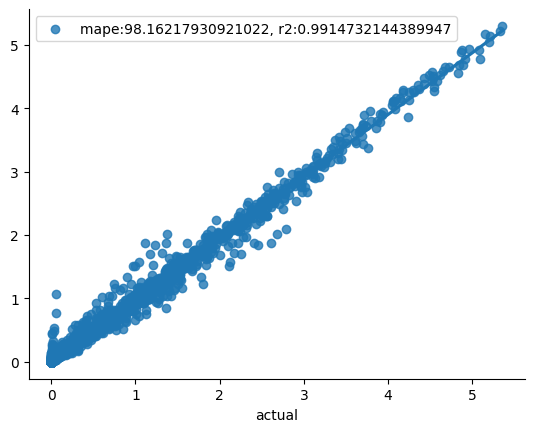

In [149]:
y_pred = regr.predict(X_train_transformed)
mape = 100 - mean_absolute_percentage_error(y_train, y_pred)
r = r2_score(y_train, y_pred)
sns.regplot(y_train, y_pred, label='mape:{}, r2:{}'.format(mape, r))
plt.legend()
sns.despine()

In [106]:
poly = PolynomialFeatures(degree=2, include_bias=False).fit(X_train_transformed)
poly_train = poly.transform(X_train_transformed)

In [107]:
linreg = LinearRegression()
linreg.fit(poly_train, y_train)

LinearRegression()

In [108]:
poly_test = poly.transform(X_test_transformed)

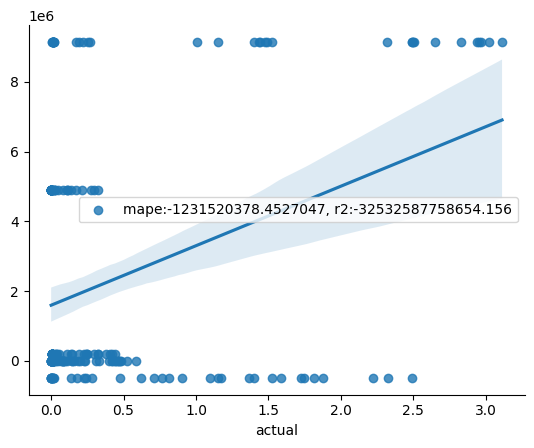

In [109]:
y_pred = linreg.predict(poly_test)
mape = 100 - mean_absolute_percentage_error(y_test, y_pred)
r = r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred, label='mape:{}, r2:{}'.format(mape, r))
plt.legend()
sns.despine()

In [53]:
ohe = OneHotEncoder(handle_unknown='ignore').fit(X.drop(['cuma', 'ara'], axis=1))
ohe_ = pd.DataFrame(ohe.transform(X.drop(['cuma', 'ara'], axis=1)).toarray())

X_ = pd.concat([X[['cuma', 'ara']].reset_index(drop=True), ohe_.reset_index(drop=True)], axis=1)
regr2 = RandomForestRegressor(n_estimators=1000)
regr2.fit(X_, y)

RandomForestRegressor(n_estimators=1000)

In [58]:
regr3 = gp.GaussianProcessRegressor()
regr3.fit(X_, y)

GaussianProcessRegressor()

In [134]:
cuma_lim = np.log10(3.125), np.log10(100)
ara_lim = np.log10(0.40625), np.log10(13)
ind1 = np.logspace(*cuma_lim, 1000)
ind2 = np.logspace(*ara_lim, 1000)

In [135]:
actual_df = X.copy()
actual_df['gate'] = actual_df['ecf'] + 'x' + actual_df['rbs-c'] + actual_df['intein']
actual_df['actual'] = y
gates = actual_df['gate'].unique()
len(gates)

119

In [61]:
#actual_df['cuma'] = actual_df['cuma'].apply(lambda x: 3.125 if x==0 else x)
#actual_df['ara'] = actual_df['ara'].apply(lambda x: 0.40625 if x==0 else x)

In [62]:
#np.log10(3.125)
#np.log10(0.40625)

In [139]:
test_pop

['e15x32CthTer', 'e38x33NrdJ1', 'e32x30SspGyrB']

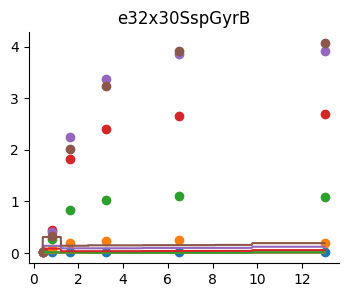

In [153]:
fig = plt.figure(figsize=[4, 3])
gate = test_pop[2]
title = gate

act_data = actual_df[actual_df['gate']==title]
act_data['cuma'] = act_data['cuma'].apply(lambda x: 3.125 if x==0 else x)
act_data['ara'] = act_data['ara'].apply(lambda x: 0.40625 if x==0 else x)

inducers = [cumas, ind2]
pred_data = pd.DataFrame(itertools.product(*inducers))
pred_data.columns = ['cuma', 'ara']
pred_data['ecf'] = gate[:3]
pred_data['intein'] = gate[6:]
pred_data['rbs-c'] = gate[4:6]

ohe_pred = pd.DataFrame(ohe.transform(pred_data.drop(['cuma', 'ara'], axis=1)).toarray())
X_gated = pd.concat([pred_data[['cuma', 'ara']].reset_index(drop=True), ohe_pred.reset_index(drop=True)], axis=1)
#X_poly = poly.transform(X_gated)
#pred_data['prediction'] = linreg.predict(X_poly)
pred_data['prediction'] = regr.predict(X_gated)

pred_data['cuma'] = pred_data['cuma'].apply(lambda x: 3.125 if x==0 else x)
pred_data['ara'] = pred_data['ara'].apply(lambda x: 0.40625 if x==0 else x)

fixed = 'cuma'
varied = 'ara'

for i in act_data[fixed].unique():
    act = act_data[act_data[fixed]==i]
    pred = pred_data[pred_data[fixed]==i]
    plt.scatter(act[varied], act['actual'])
    plt.plot(pred[varied], pred['prediction'])
    plt.title(title)
#plt.yscale('log')
#plt.loglog()
sns.despine()

In [50]:
pred_data

,cuma,ara,ecf,intein,rbs-c,prediction
0,0.0,0.406250,e15,NpuSspS2,32,-0.113323
1,0.0,0.407662,e15,NpuSspS2,32,-0.113197
2,0.0,0.409079,e15,NpuSspS2,32,-0.113070
3,0.0,0.410500,e15,NpuSspS2,32,-0.112943
4,0.0,0.411927,e15,NpuSspS2,32,-0.112815
...,...,...,...,...,...,...
5995,100.0,12.820847,e15,NpuSspS2,32,0.937842
5996,100.0,12.865403,e15,NpuSspS2,32,0.936296
5997,100.0,12.910113,e15,NpuSspS2,32,0.934715
5998,100.0,12.954978,e15,NpuSspS2,32,0.933095


In [154]:
aras = hill_activation_single(np.array(ara), *hill_params['ara'])
cumas = hill_activation_single(np.array(cuma), *hill_params['cuma'])
aras, cumas

(array([0.01071519, 1.01613432, 2.99829925, 5.57718054, 6.99365484,
        7.43778024]),
 array([0.00158489, 0.00244454, 0.00886886, 0.06103166, 0.3751241 ,
        0.98556622]))

In [155]:
actual_heatmaps = []
predicted_heatmaps = []
responses = []
for i in tqdm(range(1, 7)):
    ctrl_map = [(0, 2)] if i!=6 else [(0, 1)]
    samples_t = generate_data_at_t(folder, 'induction_matrix/plate{}'.format(i),
                                   '/induction_matrix/plate{}_map'.format(i),
                                   kind='2-input induction matrix', pos_ctrl_map=ctrl_map)[0]
    
    for gate in sorted(list(set(samples_t.index.str[:-3].tolist()))):
        
        fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
        fluo_t['cuma'] = fluo_t['name'].str[-2].astype(int)
        fluo_t['cuma'] = fluo_t['cuma'].apply(lambda x: cumas[x])
        fluo_t['ara'] = fluo_t['name'].str[-1].astype(int)
        fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])
        
        fluo_t = fluo_t.rename(columns={'8 h ': 'actual'})
        
        actual = fluo_t[['actual', 'cuma', 'ara']].pivot('cuma', 'ara')
        actual.index = [np.round(cm, 3) for cm in cumas]
        actual.columns = [np.round(ar, 3) for ar in aras]
        actual_heatmaps.append((gate, actual, fluo_t))

 33%|███████████████                              | 2/6 [00:00<00:00, 11.96it/s]

[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]
[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]
[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.25it/s]

[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]
[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]
[('A', 'sample'), ('B', 'positive')]


In [156]:
gates_list = pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder))

for i in tqdm(range(len(gates_list))):
    
    P1, P2 = gates_list.iloc[i].tolist()
    a, b = str(i*2+1).zfill(3), str(i*2+2).zfill(3)
    
    samples_t = generate_data_at_t_2(folder, '{}-{}'.format(a, b),
                                   build_plate_map(P1, P2),
                                   kind='2-input induction matrix', pos_ctrl_map=[(0, 1)],
                                   single_timepoint=True)[0]
    
    for gate in sorted(list(set(samples_t.index.str[:-3].tolist()))):
        
        fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
        fluo_t['cuma'] = fluo_t['name'].str[-2].astype(int)
        fluo_t['cuma'] = fluo_t['cuma'].apply(lambda x: cumas[x])
        fluo_t['ara'] = fluo_t['name'].str[-1].astype(int)
        fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])
        
        fluo_t = fluo_t.rename(columns={0: 'actual'})
        
        actual = fluo_t[['actual', 'cuma', 'ara']].pivot('cuma', 'ara')
        actual.index = [np.round(cm, 3) for cm in cumas]
        actual.columns = [np.round(ar, 3) for ar in aras]
        actual_heatmaps.append((gate, actual, fluo_t))

100%|███████████████████████████████████████████| 55/55 [00:02<00:00, 23.03it/s]


In [157]:
len(actual_heatmaps)

121

### Feature Engineering

In [158]:
pop = [i[0] for i in actual_heatmaps]
np.random.shuffle(pop)
test_size = 0.03
test_pop = pop[:int(len(pop)*test_size)]
train_pop = pop[len(test_pop):]
len(pop), len(train_pop)+len(test_pop)

(121, 121)

In [159]:
samples = pd.concat([i[2] for i in actual_heatmaps], axis=0)
samples['ecf'] = samples['name'].apply(lambda x: str(x[:3]))
samples['intein'] = samples['name'].apply(lambda x: str(x[6:-3]))
samples['rbs-c'] = samples['name'].apply(lambda x: str(x[4:6]))
samples.drop('name', axis=1, inplace=True)
len(samples)

4356

In [160]:
samples_train = pd.concat([i[2] for i in actual_heatmaps if i[0] in train_pop], axis=0)
samples_train['ecf'] = samples_train['name'].apply(lambda x: str(x[:3]))
samples_train['intein'] = samples_train['name'].apply(lambda x: str(x[6:-3]))
samples_train['rbs-c'] = samples_train['name'].apply(lambda x: str(x[4:6]))
samples_train.drop('name', axis=1, inplace=True)
len(samples_train)

4248

In [161]:
samples_test = pd.concat([i[2] for i in actual_heatmaps if i[0] in test_pop], axis=0)
samples_test['ecf'] = samples_test['name'].apply(lambda x: str(x[:3]))
samples_test['intein'] = samples_test['name'].apply(lambda x: str(x[6:-3]))
samples_test['rbs-c'] = samples_test['name'].apply(lambda x: str(x[4:6]))
samples_test.drop('name', axis=1, inplace=True)
len(samples_test)

108

In [162]:
#y = samples['actual']
#X = samples.drop('actual', axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [163]:
X_train = samples_train.drop('actual', axis=1)
y_train = samples_train['actual']
X_test = samples_test.drop('actual', axis=1)
y_test = samples_test['actual']

In [164]:
ohe = OneHotEncoder(handle_unknown='ignore').fit(X_train.drop(['cuma', 'ara'], axis=1))
ohe_train = pd.DataFrame(ohe.transform(X_train.drop(['cuma', 'ara'], axis=1)).toarray())
ohe_test = pd.DataFrame(ohe.transform(X_test.drop(['cuma', 'ara'], axis=1)).toarray())

X_train_transformed = pd.concat([X_train[['cuma', 'ara']].reset_index(drop=True),
                                 ohe_train.reset_index(drop=True)], axis=1)
X_test_transformed = pd.concat([X_test[['cuma', 'ara']].reset_index(drop=True),
                                ohe_test.reset_index(drop=True)], axis=1)

In [167]:
regr = RandomForestRegressor(n_estimators=1000)
regr.fit(X_train_transformed[['cuma', 'ara']], y_train)

RandomForestRegressor(n_estimators=1000)

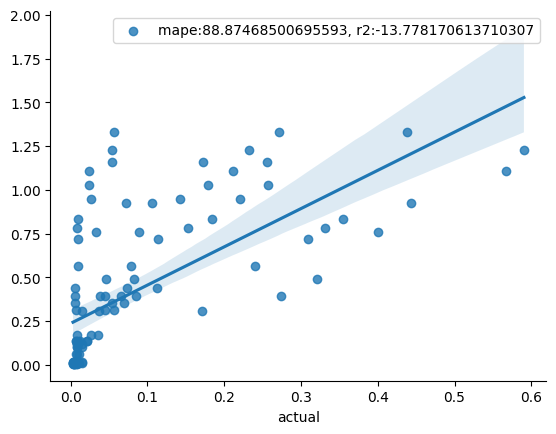

In [168]:
y_pred = regr.predict(X_test_transformed[['cuma', 'ara']])
mape = 100 - mean_absolute_percentage_error(y_test, y_pred)
r = r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred, label='mape:{}, r2:{}'.format(mape, r))
plt.legend()
sns.despine()

In [ ]:
#kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor()
model.fit(X_train_transformed, y_train)

In [ ]:
y_pred = model.predict(X_test_transformed)
mape = 100 - mean_absolute_percentage_error(y_test, y_pred)
r = r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred, label='mape:{}, r2:{}'.format(mape, r))
plt.legend()
sns.despine()

In [18]:
poly = PolynomialFeatures(degree=2, include_bias=False).fit(X_train_transformed)
poly_train = poly.transform(X_train_transformed)

In [19]:
linreg = LinearRegression()
linreg.fit(poly_train, y_train)

LinearRegression()

In [20]:
poly_test = poly.transform(X_test_transformed)

In [ ]:
y_pred = linreg.predict(poly_test)
mape = 100 - mean_absolute_percentage_error(y_test, y_pred)
r = r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred, label='mape:{}, r2:{}'.format(mape, r))
plt.legend()
sns.despine()

### All data

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore').fit(X.drop(['cuma', 'ara'], axis=1))
ohe_ = pd.DataFrame(ohe.transform(X.drop(['cuma', 'ara'], axis=1)).toarray())

X_ = pd.concat([X[['cuma', 'ara']].reset_index(drop=True), ohe_.reset_index(drop=True)], axis=1)
regr2 = RandomForestRegressor(n_estimators=1000)
regr2.fit(X_, y)

RandomForestRegressor(n_estimators=1000)

In [13]:
y_ = regr2.predict(X_)

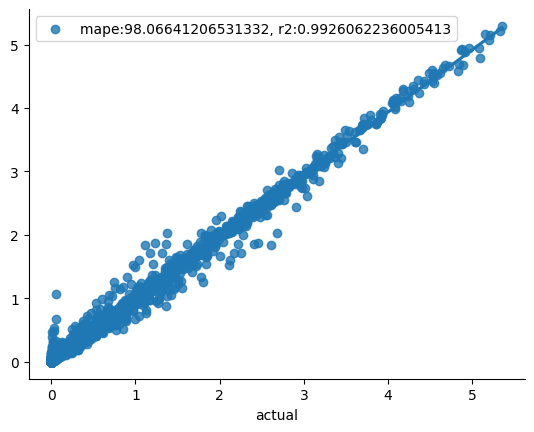

In [14]:
mape = 100 - mean_absolute_percentage_error(y, y_)
r = r2_score(y, y_)
sns.regplot(y, y_, label='mape:{}, r2:{}'.format(mape, r))
plt.legend()
sns.despine()

In [ ]:
model = gp.GaussianProcessRegressor()
model.fit(X_, y)

In [ ]:
y_ = model.predict(X_)
mape = 100 - mean_absolute_percentage_error(y, y_)
r = r2_score(y, y_)
sns.regplot(y, y_, label='mape:{}, r2:{}'.format(mape, r))
plt.legend()
sns.despine()

In [ ]:
linreg = LinearRegression()
linreg.fit(X_, y)

In [ ]:
y_ = linreg.predict(X_)

### Visualization breakdown

In [21]:
cuma_lim = np.log10(min(cumas)), np.log10(max(cumas))
ara_lim = np.log10(min(aras)), np.log10(max(aras))
ind1 = np.logspace(*cuma_lim, 1000)
ind2 = np.logspace(*ara_lim, 1000)

In [22]:
actual_df = X.copy()
actual_df['gate'] = actual_df['ecf'] + 'x' + actual_df['rbs-c'] + actual_df['intein']
actual_df['actual'] = y
gates = actual_df['gate'].unique()
len(gates)

119

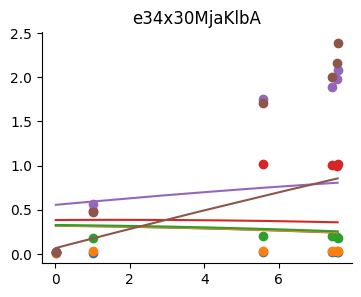

In [23]:
fig = plt.figure(figsize=[4, 3])
gate = gates[5]
title = gate

act_data = actual_df[actual_df['gate']==title]
inducers = [cumas, ind2]
pred_data = pd.DataFrame(itertools.product(*inducers))
pred_data.columns = ['cuma', 'ara']
pred_data['ecf'] = gate[:3]
pred_data['intein'] = gate[6:]
pred_data['rbs-c'] = gate[4:6]

ohe_pred = pd.DataFrame(ohe.transform(pred_data.drop(['cuma', 'ara'], axis=1)).toarray())
X_gated = pd.concat([pred_data[['cuma', 'ara']].reset_index(drop=True), ohe_pred.reset_index(drop=True)], axis=1)
X_poly = poly.transform(X_gated)
pred_data['prediction'] = linreg.predict(X_poly)

fixed = 'cuma'
varied = 'ara'

for i in act_data[fixed].unique():
    act = act_data[act_data[fixed]==i]
    pred = pred_data[pred_data[fixed]==i]
    plt.scatter(act[varied], act['actual'])
    plt.plot(pred[varied], pred['prediction'])
    plt.title(title)
#plt.yscale('log')
#plt.loglog()
sns.despine()

#### Prediction One Gate

In [173]:
X1 = actual_heatmaps[0][2][['cuma', 'ara']]
y1 = actual_heatmaps[0][2]['actual']

In [225]:
poly = PolynomialFeatures(degree=2, include_bias=False).fit(X1)
#X1_poly = poly.transform(X1)
regr = gp.GaussianProcessRegressor()#RandomForestRegressor(n_estimators=1000)
regr.fit(X1, y1)

GaussianProcessRegressor()

In [418]:
kernel = gp.kernels.ConstantKernel(10, constant_value_bounds="fixed") * gp.kernels.RBF(10, length_scale_bounds="fixed")
model = gp.GaussianProcessRegressor(kernel=kernel)
model.fit(X1, y1)

GaussianProcessRegressor(kernel=3.16**2 * RBF(length_scale=10))

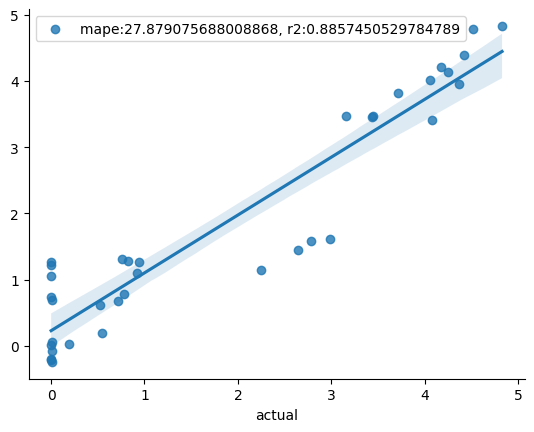

In [419]:
y1_ = model.predict(X1)
mape = 100 - mean_absolute_percentage_error(y1, y1_)
r = r2_score(y1, y1_)
sns.regplot(y1, y1_, label='mape:{}, r2:{}'.format(mape, r))
plt.legend()
sns.despine()

In [420]:
cuma_lim = np.log10(0.001585), np.log10(0.985566)
ara_lim = np.log10(0.010715), np.log10(7.437780)
ind1 = np.logspace(*cuma_lim, 1000)
ind2 = np.logspace(*ara_lim, 1000)

In [421]:
cumas = actual_heatmaps[0][2]['cuma'].unique()

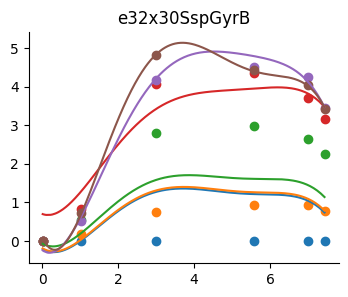

In [422]:
fig = plt.figure(figsize=[4, 3])
#gate = gates[5]
#title = gate

#act_data = actual_df[actual_df['gate']==title]
act_data = actual_heatmaps[0][2]
inducers = [cumas, ind2]
pred_data = pd.DataFrame(itertools.product(*inducers))
pred_data.columns = ['cuma', 'ara']
#pred_data['ecf'] = gate[:3]
#pred_data['intein'] = gate[6:]
#pred_data['rbs-c'] = gate[4:6]

#ohe_pred = pd.DataFrame(ohe.transform(pred_data.drop(['cuma', 'ara'], axis=1)).toarray())
#X_gated = pd.concat([pred_data[['cuma', 'ara']].reset_index(drop=True), ohe_pred.reset_index(drop=True)], axis=1)
#X_poly = poly.transform(X_gated)
#pred_data_poly = poly.transform(pred_data)
pred_data['prediction'] = model.predict(pred_data)

fixed = 'cuma'
varied = 'ara'

for i in act_data[fixed].unique():
    act = act_data[act_data[fixed]==i]
    pred = pred_data[pred_data[fixed]==i]
    plt.scatter(act[varied], act['actual'], label=i)
    plt.plot(pred[varied], pred['prediction'])
plt.title(title)
#plt.legend()
#plt.yscale('log')
#plt.loglog()
sns.despine()

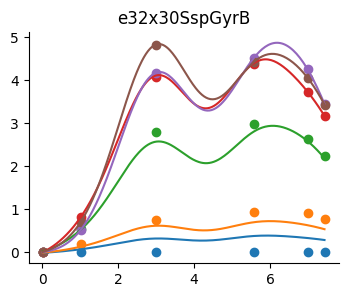

In [377]:
fig = plt.figure(figsize=[4, 3])
#gate = gates[5]
#title = gate

#act_data = actual_df[actual_df['gate']==title]
act_data = actual_heatmaps[0][2]
inducers = [cumas, ind2]
pred_data = pd.DataFrame(itertools.product(*inducers))
pred_data.columns = ['cuma', 'ara']
#pred_data['ecf'] = gate[:3]
#pred_data['intein'] = gate[6:]
#pred_data['rbs-c'] = gate[4:6]

#ohe_pred = pd.DataFrame(ohe.transform(pred_data.drop(['cuma', 'ara'], axis=1)).toarray())
#X_gated = pd.concat([pred_data[['cuma', 'ara']].reset_index(drop=True), ohe_pred.reset_index(drop=True)], axis=1)
#X_poly = poly.transform(X_gated)
#pred_data_poly = poly.transform(pred_data)
pred_data['prediction'] = model.predict(pred_data)

fixed = 'cuma'
varied = 'ara'

for i in act_data[fixed].unique():
    act = act_data[act_data[fixed]==i]
    pred = pred_data[pred_data[fixed]==i]
    plt.scatter(act[varied], act['actual'], label=i)
    plt.plot(pred[varied], pred['prediction'])
plt.title(title)
#plt.legend()
#plt.yscale('log')
#plt.loglog()
sns.despine()

In [336]:
act_data

,name,actual,cuma,ara
0,e11x32STPhoRadA_00,0.001785,0.001585,0.010715
1,e11x32STPhoRadA_01,0.003042,0.001585,1.016134
2,e11x32STPhoRadA_02,0.001504,0.001585,2.998299
3,e11x32STPhoRadA_03,0.001901,0.001585,5.577181
4,e11x32STPhoRadA_04,0.002020,0.001585,6.993655
5,e11x32STPhoRadA_05,0.003990,0.001585,7.437780
6,e11x32STPhoRadA_10,0.001196,0.002445,0.010715
7,e11x32STPhoRadA_11,0.192623,0.002445,1.016134
8,e11x32STPhoRadA_12,0.762740,0.002445,2.998299
9,e11x32STPhoRadA_13,0.939117,0.002445,5.577181


In [335]:
pred_data

,cuma,ara,prediction
0,0.001585,0.010715,1.784803e-03
1,0.001585,0.010785,3.522305e-14
2,0.001585,0.010856,1.075224e-46
3,0.001585,0.010928,1.886504e-101
4,0.001585,0.010999,6.962281e-179
...,...,...,...
5995,0.985566,7.245463,0.000000e+00
5996,0.985566,7.293071,0.000000e+00
5997,0.985566,7.340992,0.000000e+00
5998,0.985566,7.389227,0.000000e+00


In [ ]:
fig = plt.figure(figsize=[4, 3])
for i in act_data[fixed].unique():
    act = act_data[act_data[fixed]==i]
    pred = pred_data[pred_data[fixed]==i]
    plt.scatter(act[varied], act['actual'])
    plt.plot(pred[varied], pred['prediction'])
    plt.title(title)
plt.yscale('log')
plt.loglog()
sns.despine()

In [ ]:
for i in act_data[fixed].unique():
    act = act_data[act_data[fixed]==i]
    pred = pred_data[pred_data[fixed]==i]
    plt.scatter(act[varied], act['actual'])
    plt.plot(pred[varied], pred['prediction'])
    plt.title(title)
#plt.yscale('log')
plt.loglog()
sns.despine()

In [ ]:
inducers = [cumas, ind2]
data = pd.DataFrame(itertools.product(*inducers))
df.columns = ['cuma', 'ara']
df['ecf'] = 'e11'
df['intein'] = 'STPhoRadA'
df['rbs-c'] = '32'
df

In [ ]:
data = df[df['']]

In [ ]:
inducers = [cumas, ind2]
df = pd.DataFrame(itertools.product(*inducers))
df.columns = ['cuma', 'ara']
df['ecf'] = 'e11'
df['intein'] = 'STPhoRadA'
df['rbs-c'] = '32'
df

In [ ]:
inducers = [cumas, ind2]
df = pd.DataFrame(itertools.product(*inducers))
df.columns = ['cuma', 'ara']
df['ecf'] = 'e11'
df['intein'] = 'STPhoRadA'
df['rbs-c'] = '32'



ohe_gated = pd.DataFrame(ohe.transform(df.drop(['cuma', 'ara'], axis=1)).toarray())
X_gated = pd.concat([df[['cuma', 'ara']].reset_index(drop=True), ohe_gated.reset_index(drop=True)], axis=1)
df['prediction'] = regr2.predict(X_gated)
df['cuma'] = df['cuma'].apply(lambda x: 3.125 if x==0 else x)
df['ara'] = df['ara'].apply(lambda x: 0.203125 if x==0 else x)

In [ ]:
fig = plt.figure(figsize=[4, 3])
title = 'e11x32STPhoRadA'
X2 = X.copy()
X2['actual'] = y
X2['prediction'] = y_
X2['gate'] = X2['ecf'] + 'x' + X2['rbs-c'] + X2['intein']
#X2 = X2.drop(['ecf', 'rbs-c', 'intein'], axis=1)
gated = X2[X2['gate']==title]
gated['cuma'] = gated['cuma'].apply(lambda x: 3.125 if x==0 else x)
gated['ara'] = gated['ara'].apply(lambda x: 0.203125 if x==0 else x)
for i in gated['ara'].unique():
    data = gated[gated['ara']==i]
    data2 = df[df['ara']==i]
    plt.scatter(data['cuma'], data['actual'])
    #plt.plot(data['ara'], data['prediction'])
    plt.plot(data2['cuma'], data2['prediction'])
    plt.title(title)
plt.loglog()
sns.despine()

In [ ]:
data2 = df[df['cuma']==0]
data2

In [ ]:
data2

In [ ]:
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
forest_importances = pd.Series(regr.feature_importances_, index=['cuma', 'ara'] + [i.split('_')[1] for i in ohe.get_feature_names().tolist()])
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
all_scores = []
for i in tqdm(range(20)):
    scores = cross_validate(RandomForestRegressor(), X_train_transformed, y_train,
                            cv=10, scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
    all_scores.append([-i for i in scores['test_neg_mean_absolute_error']])

In [ ]:
sns.kdeplot(np.array(all_scores).flatten())
sns.despine()

In [ ]:
np.mean([-i for i in scores['test_neg_mean_absolute_error']])

In [ ]:
all_scores = []
for i in tqdm(range(1)):
    scores = cross_validate(RandomForestRegressor(), X_train_transformed, y_train,
                            cv=10, scoring=('r2_score', 'neg_mean_absolute_error'), return_train_score=True)
    all_scores.append([-i for i in scores['test_r2']])

In [ ]:
sns.kdeplot(np.array(all_scores).flatten())
sns.despine()

### Hyperparameter Optimization

In [ ]:
# Number of trees in random forest
n_estimators = [100, 1000]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 100]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore').fit_transform(X).toarray()
X_transformed = pd.concat([X[['cuma', 'ara']].reset_index(drop=True), pd.DataFrame(ohe).reset_index(drop=True)], axis=1)

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_transformed, y)

In [ ]:
rf_random.best_params_

In [ ]:
df = pd.read_csv('datasets/data-driven-121.csv').append(pd.read_csv('datasets/data-driven-121_syn.csv'))
df

In [ ]:
y = df['actual']
X = df.drop('actual', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ohe = OneHotEncoder(handle_unknown='ignore').fit(X_train.drop(['cuma', 'ara'], axis=1))
ohe_train = pd.DataFrame(ohe.transform(X_train.drop(['cuma', 'ara'], axis=1)).toarray())
ohe_test = pd.DataFrame(ohe.transform(X_test.drop(['cuma', 'ara'], axis=1)).toarray())

X_train_transformed = pd.concat([X_train[['cuma', 'ara']].reset_index(drop=True), ohe_train.reset_index(drop=True)], axis=1)
X_test_transformed = pd.concat([X_test[['cuma', 'ara']].reset_index(drop=True), ohe_test.reset_index(drop=True)], axis=1)

regr = RandomForestRegressor(n_estimators=100)
regr.fit(X_train_transformed, y_train)

In [ ]:
y_pred = regr.predict(X_test_transformed)
100 - mean_absolute_percentage_error(y_test, y_pred)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
sns.regplot(y_test, y_pred)
sns.despine()